# Визуализация данных и сгенерированных дескрипторов

In [10]:
import sys
import pandas as pd
import random
from pandas import DataFrame
import numpy as np
import time
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
import os

from rdkit.Chem import Descriptors, SDMolSupplier
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

RANDOM_STATE=28112024

from utils import start, min_max_scaler, standard_scaler
from generate_descriptors import (load_molecules, get_descriptors, remove_duplicates, remove_nan, 
                                    calc_all_descriptors, get_all_descriptors, remove_data_target)
from functions_visualization import heatmap, display_images

import warnings
warnings.filterwarnings("ignore")

# 1. Настройки

In [14]:
start()


Версии программного обеспечения, использованные в данной практической работе: 
python                    3.12.3
numpy                     2.0.1
tqdm                      4.66.2
rdkit                     2024.3.5
matplotlib-inline         0.1.6


# 2. Взгляд на данные

In [3]:
# читаем из файла и создаем список молекул
molecules = load_molecules("../data/learning/logBCF.sdf")
print(f'Количество молекул = {len(molecules)}')

Количество молекул = 777


[00:18:47] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:18:47] ERROR: Could not sanitize molecule ending on line 6092
[00:18:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6
[00:18:47] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13
[00:18:47] ERROR: Could not sanitize molecule ending on line 7708
[00:18:47] ERROR: Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 10 11 12 13


In [4]:
print(molecules[55].GetPropsAsDict()) 

{'logBCF': 1.04, 'class': 2}


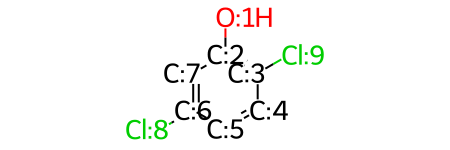

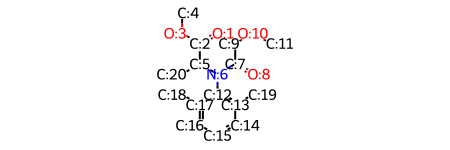

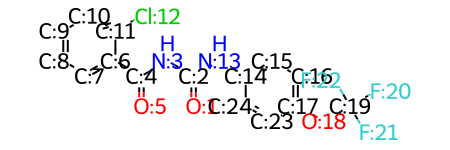

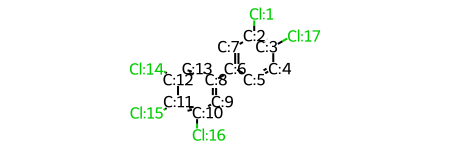

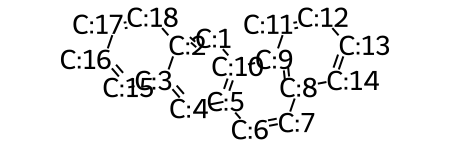

In [5]:
# Выведем несколько рандомных молекул
random_molecules = random.sample(molecules, 5)
for mol in random_molecules:
    display(mol)

In [6]:
base_descriptors, descriptors_transformer = get_descriptors(molecules)
display(descriptors_transformer)
display(base_descriptors.head())

FunctionTransformer(func=<function mol_dsc_calc at 0x7ff846820400>)

,heavy_atom_count,nhoh_count,no_count,num_h_acceptors,num_h_donors,num_heteroatoms,num_rotatable_bonds,num_valence_electrons,num_aromatic_rings,num_Aliphatic_heterocycles,ring_count,full_molecular_weight,log_p,molecular_refractivity,tspa,balaban_j
0,10,1,4,3,1,4,1,52,1,0,1,139.110,1.3004,34.7612,63.37,3.0034
1,11,0,4,3,0,4,2,58,1,0,1,153.137,1.6034,39.6484,52.37,2.9138
2,12,0,0,0,0,0,2,66,1,0,1,162.276,3.9334,54.6200,0.00,2.8556
3,12,0,6,4,0,6,2,62,1,0,1,168.108,1.5030,39.7508,86.28,3.0061
4,8,0,0,0,0,0,1,44,0,0,1,108.184,2.5287,36.6780,0.00,2.3714


,heavy_atom_count,nhoh_count,no_count,num_h_acceptors,num_h_donors,num_heteroatoms,num_rotatable_bonds,num_valence_electrons,num_aromatic_rings,num_Aliphatic_heterocycles,ring_count,full_molecular_weight,log_p,molecular_refractivity,tspa,balaban_j
count,777.0000,777.0000,777.0000,777.000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000,777.0000
mean,15.1660,0.5586,2.3681,2.148,0.4788,4.4916,2.5006,81.4080,1.2857,0.0811,1.5058,249.9002,3.4984,61.9508,32.2689,2.8226
std,6.2456,0.8907,2.2529,2.025,0.7088,3.4656,2.9502,33.8986,0.9198,0.3001,1.0129,109.0178,1.8624,22.4834,30.1959,0.7276
min,3.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,16.0000,0.0000,0.0000,0.0000,68.0750,-2.1952,16.5730,0.0000,1.3177
25%,10.0000,0.0000,1.0000,1.000,0.0000,2.0000,0.0000,56.0000,1.0000,0.0000,1.0000,167.2580,2.2137,43.1164,3.2400,2.3209
50%,15.0000,0.0000,2.0000,2.000,0.0000,4.0000,1.0000,76.0000,1.0000,0.0000,1.0000,233.0980,3.3211,60.2900,26.3000,2.7954
75%,19.0000,1.0000,4.0000,4.000,1.0000,6.0000,4.0000,100.0000,2.0000,0.0000,2.0000,316.4270,4.5840,77.9293,50.9400,3.1673
max,55.0000,6.0000,16.0000,10.000,4.0000,37.0000,21.0000,330.0000,5.0000,3.0000,6.0000,959.1710,11.1039,157.2075,185.5200,7.8308


,heavy_atom_count,nhoh_count,no_count,num_h_acceptors,num_h_donors,num_heteroatoms,num_rotatable_bonds,num_valence_electrons,num_aromatic_rings,num_Aliphatic_heterocycles,ring_count,full_molecular_weight,log_p,molecular_refractivity,tspa,balaban_j
353,11,2,1,1,1,5,0,60,1,0,1,230.909,3.8824,50.8944,26.02,3.4555
539,11,2,1,1,1,5,0,60,1,0,1,230.909,3.8824,50.8944,26.02,3.4555
541,10,2,1,1,1,4,0,54,1,0,1,196.464,3.2290,45.8844,26.02,3.3105
542,10,2,1,1,1,4,0,54,1,0,1,196.464,3.2290,45.8844,26.02,3.3105


'Количество явных дубликатов: 4'

array([[<Axes: title={'center': 'heavy_atom_count'}>,
        <Axes: title={'center': 'nhoh_count'}>,
        <Axes: title={'center': 'no_count'}>,
        <Axes: title={'center': 'num_h_acceptors'}>],
       [<Axes: title={'center': 'num_h_donors'}>,
        <Axes: title={'center': 'num_heteroatoms'}>,
        <Axes: title={'center': 'num_rotatable_bonds'}>,
        <Axes: title={'center': 'num_valence_electrons'}>],
       [<Axes: title={'center': 'num_aromatic_rings'}>,
        <Axes: title={'center': 'num_Aliphatic_heterocycles'}>,
        <Axes: title={'center': 'ring_count'}>,
        <Axes: title={'center': 'full_molecular_weight'}>],
       [<Axes: title={'center': 'log_p'}>,
        <Axes: title={'center': 'molecular_refractivity'}>,
        <Axes: title={'center': 'tspa'}>,
        <Axes: title={'center': 'balaban_j'}>]], dtype=object)

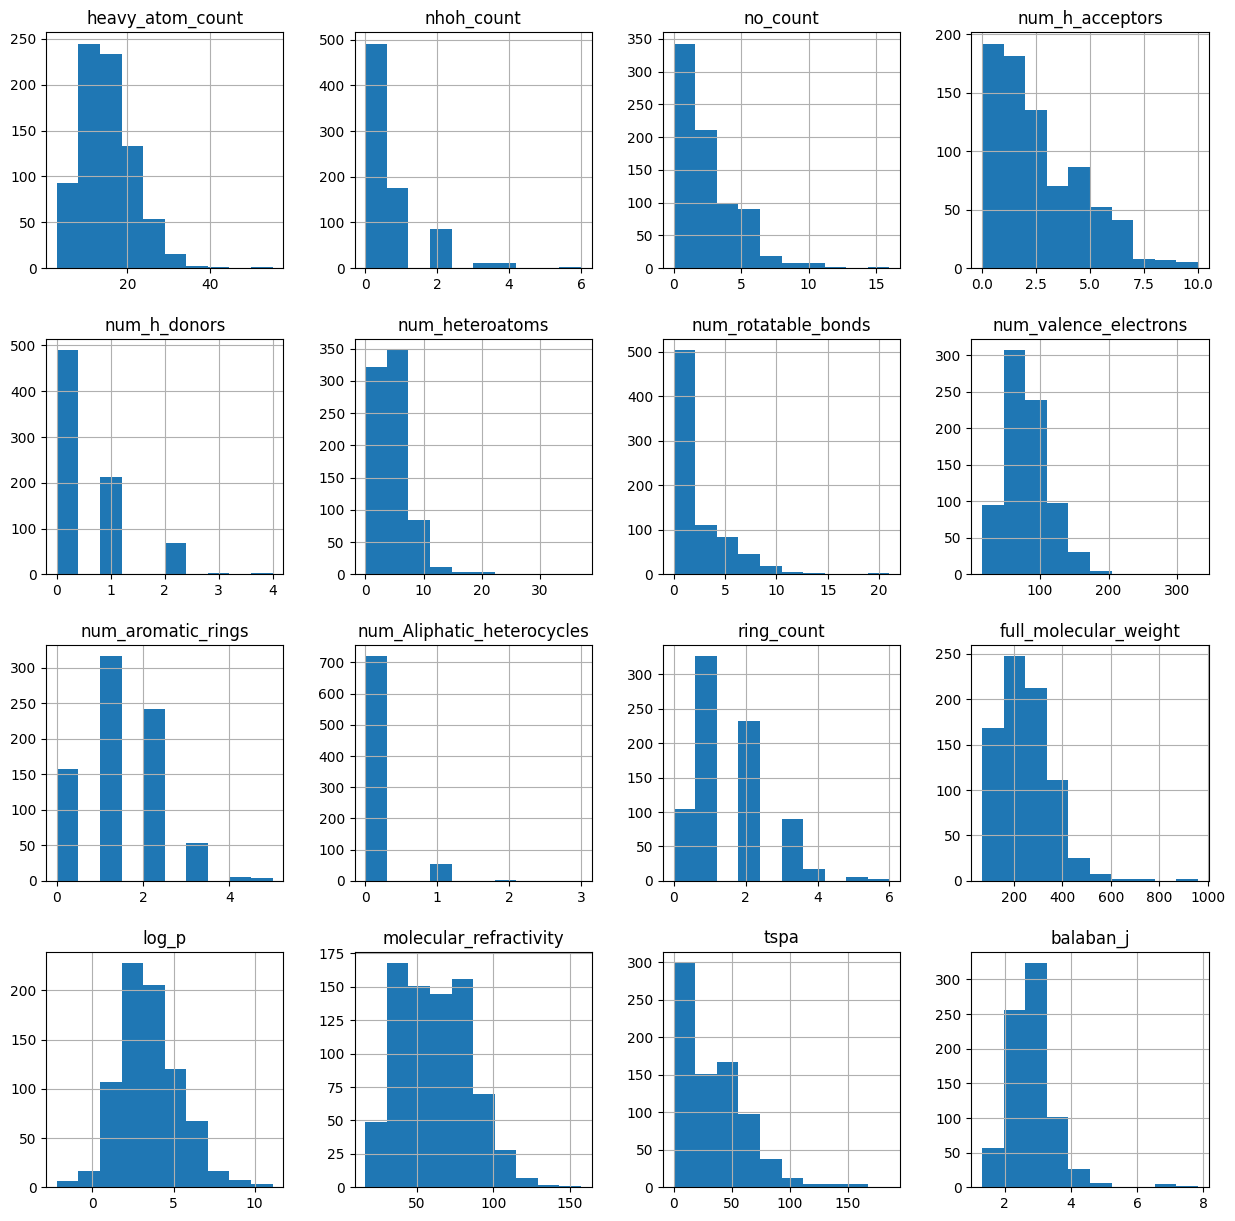

In [7]:
display(base_descriptors.describe())
display(base_descriptors[base_descriptors.duplicated(keep = False)]) # явные дубликаты отсутствуют
display(f"Количество явных дубликатов: {len(base_descriptors[base_descriptors.duplicated(keep = False)])}")
display(base_descriptors.hist(figsize=(15,15)))
plt.show()

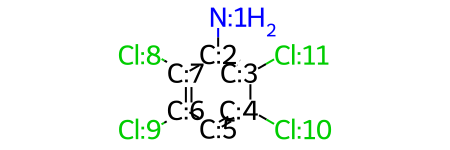

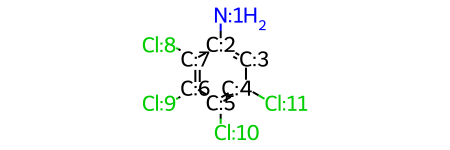

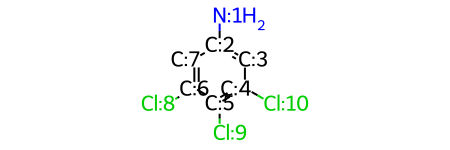

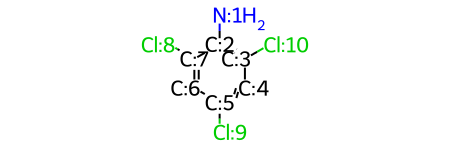

In [8]:
# Смотрим на дубликаты
for mol in list(base_descriptors[base_descriptors.duplicated(keep = False)].index):
    display(molecules[mol])

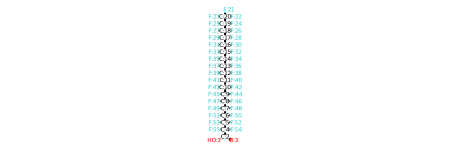

In [9]:
# Перед удалением дубликатов посмотрим на самую тяжелую молекулу по HAC
molecules[list(base_descriptors[base_descriptors['heavy_atom_count'] == base_descriptors['heavy_atom_count'].max()].index)[0]]

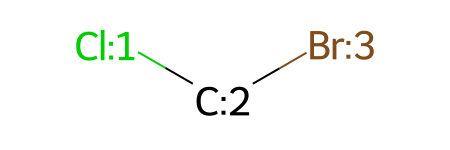

In [10]:
# и на самую легкую по HAC 
molecules[list(base_descriptors[base_descriptors['heavy_atom_count'] == base_descriptors['heavy_atom_count'].min()].index)[0]]

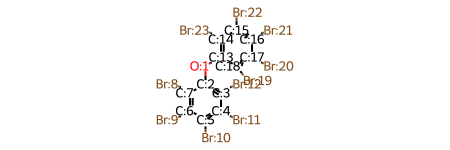

In [11]:
# Перед удалением дубликатов посмотрим на самую тяжелую молекулу по молекулярному весу
molecules[list(base_descriptors[base_descriptors['full_molecular_weight'] == base_descriptors['full_molecular_weight'].max()].index)[0]]

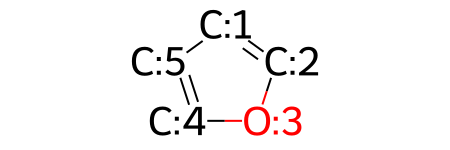

In [12]:
# и на самую легкую по молекулярному весу
molecules[list(base_descriptors[base_descriptors['full_molecular_weight'] == base_descriptors['full_molecular_weight'].min()].index)[0]]

In [13]:
base_descriptors = remove_duplicates(base_descriptors)
display(base_descriptors.tail(3))

,heavy_atom_count,nhoh_count,no_count,num_h_acceptors,num_h_donors,num_heteroatoms,num_rotatable_bonds,num_valence_electrons,num_aromatic_rings,num_Aliphatic_heterocycles,ring_count,full_molecular_weight,log_p,molecular_refractivity,tspa,balaban_j
772,12,0,6,4,0,6,2,62,1,0,1,168.108,1.5030,39.7508,86.28,3.1218
773,11,1,1,1,1,1,2,60,1,0,1,150.221,2.9057,46.8128,20.23,2.8057
774,10,0,3,2,0,3,1,52,1,0,1,137.138,1.9032,37.8334,43.14,3.0034


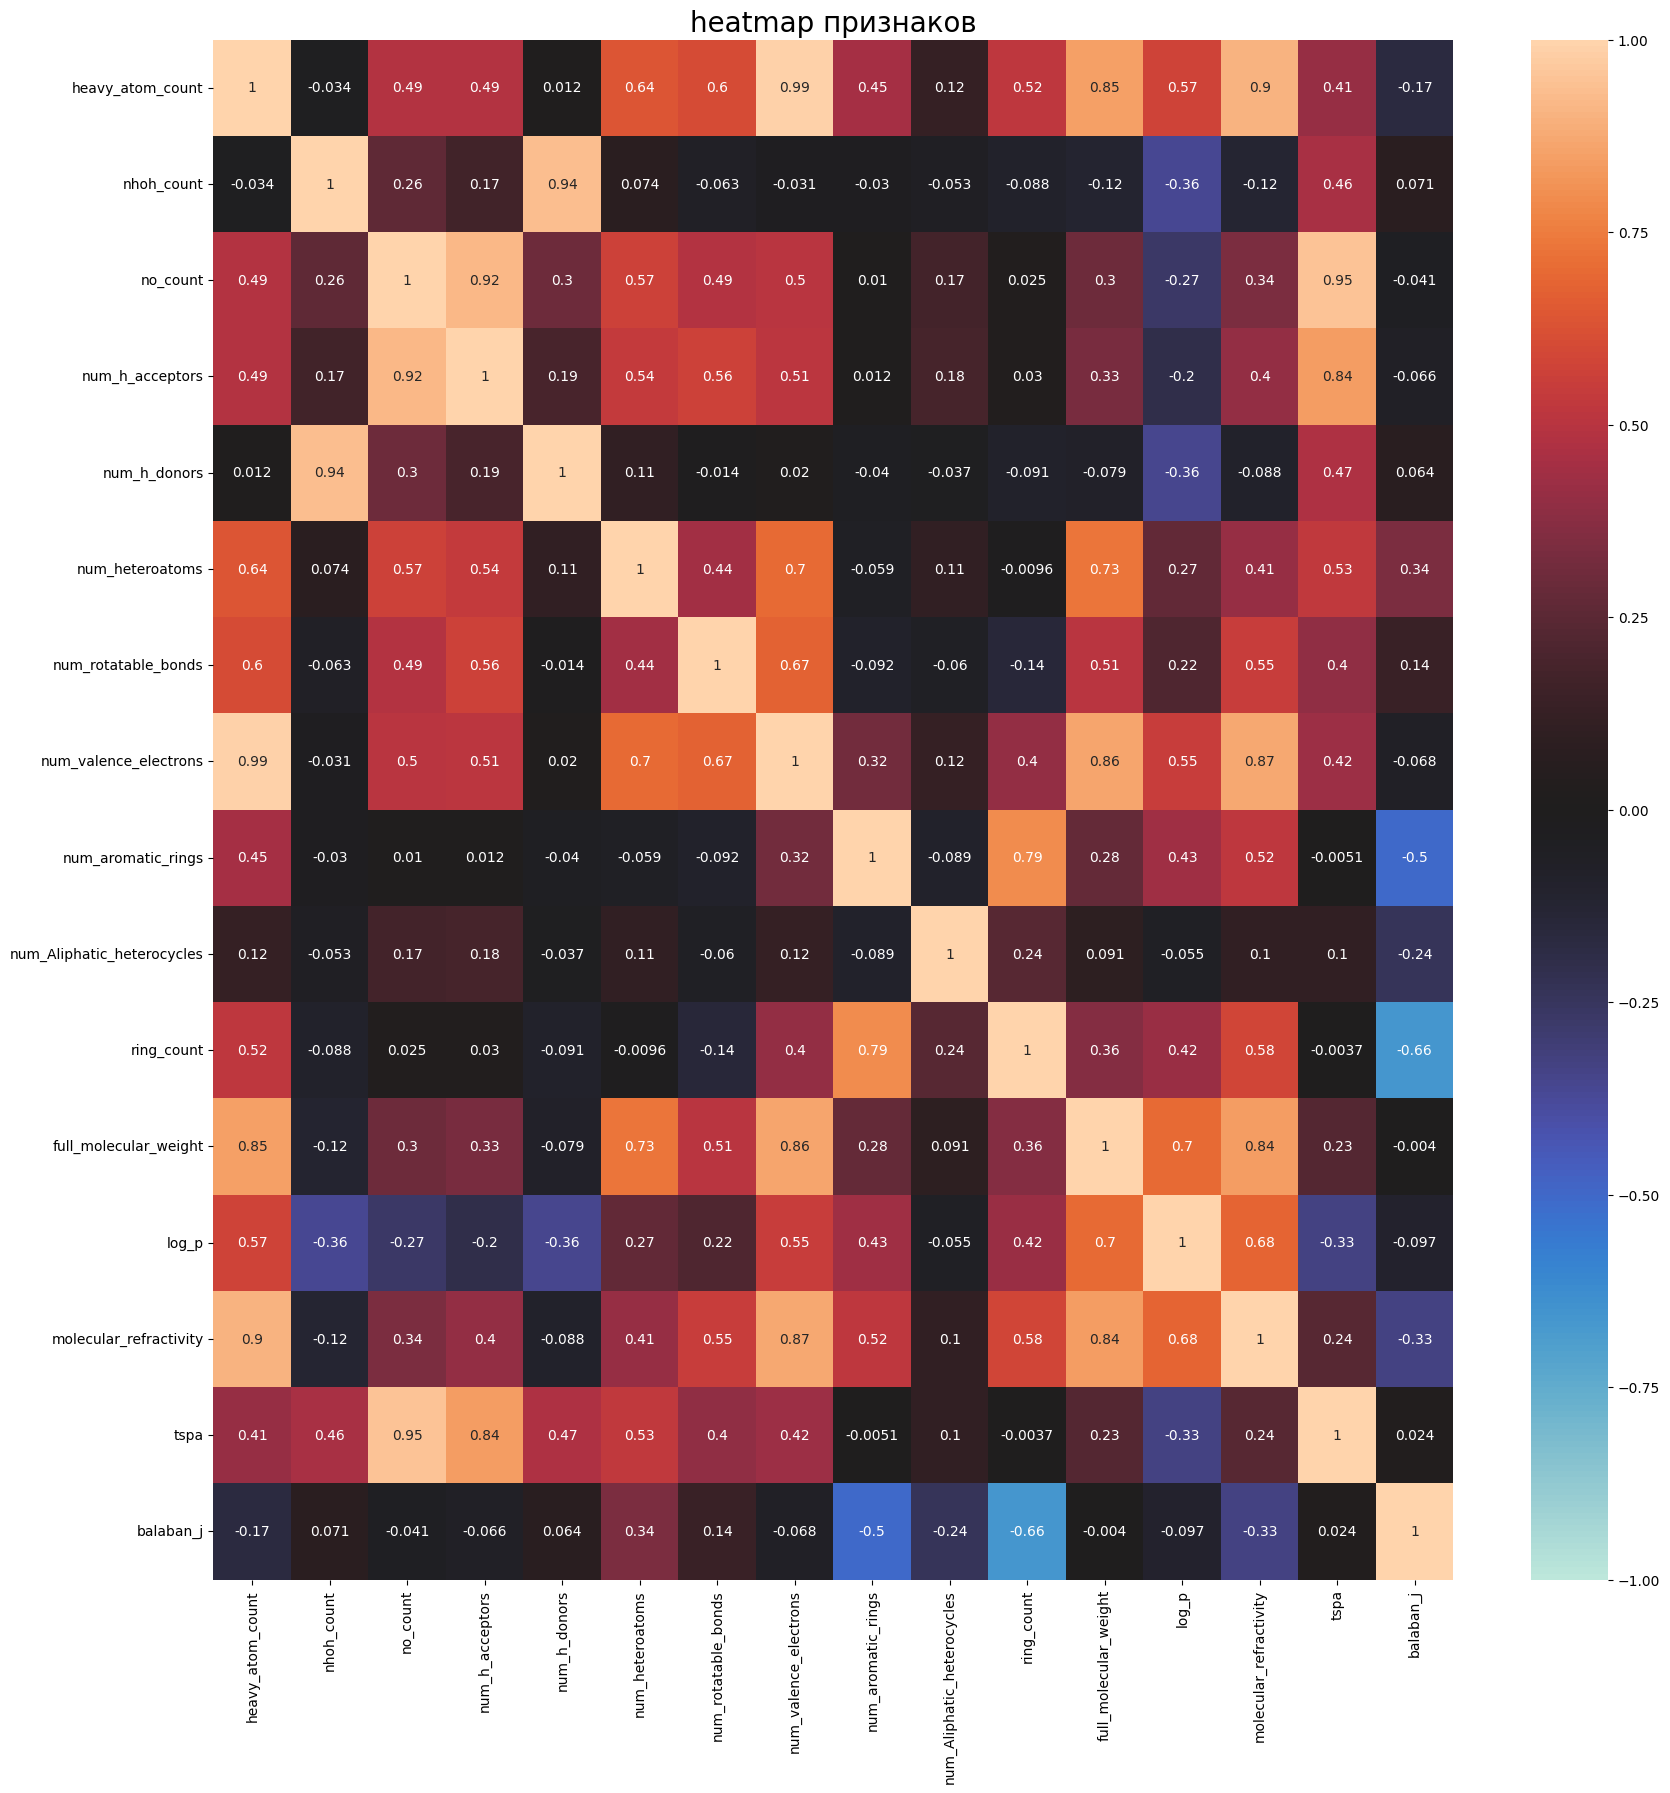

In [14]:
heatmap(base_descriptors, "./output_data/visual_base_data", "heatmap_features.png")

# 3. Все дескрипторы

In [15]:
descriptors_list = [calc_all_descriptors(mol) for mol in molecules]
all_descriptors = pd.DataFrame(descriptors_list)

In [16]:
all_descriptors[all_descriptors.duplicated()]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea


In [17]:
all_descriptors.columns[(all_descriptors == 0).all()] # признаки, которые во всех молекулах = 0

Index(['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'EState_VSA11',
       'fr_HOCCN', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzodiazepine',
       'fr_diazo', 'fr_dihydropyridine', 'fr_isocyan', 'fr_isothiocyan',
       'fr_lactam', 'fr_prisulfonamd', 'fr_quatN', 'fr_tetrazole'],
      dtype='object')

In [18]:
list(all_descriptors.columns[(all_descriptors == 0).sum() > len(all_descriptors) / 2]) # признаки, которые = 0 в половине датафрейме

['NumRadicalElectrons',
 'PEOE_VSA10',
 'PEOE_VSA11',
 'PEOE_VSA12',
 'PEOE_VSA13',
 'PEOE_VSA14',
 'PEOE_VSA2',
 'PEOE_VSA3',
 'PEOE_VSA4',
 'PEOE_VSA5',
 'SMR_VSA2',
 'SMR_VSA3',
 'SMR_VSA4',
 'SMR_VSA6',
 'SMR_VSA8',
 'SMR_VSA9',
 'SlogP_VSA1',
 'SlogP_VSA10',
 'SlogP_VSA11',
 'SlogP_VSA3',
 'SlogP_VSA4',
 'SlogP_VSA7',
 'SlogP_VSA8',
 'SlogP_VSA9',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA7',
 'EState_VSA8',
 'VSA_EState1',
 'VSA_EState2',
 'VSA_EState7',
 'VSA_EState8',
 'VSA_EState9',
 'NHOHCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticHeterocycles',
 'NumHDonors',
 'NumSaturatedCarbocycles',
 'NumSaturatedHeterocycles',
 'NumSaturatedRings',
 'fr_Al_COO',
 'fr_Al_OH',
 'fr_Al_OH_noTert',
 'fr_ArN',
 'fr_Ar_COO',
 'fr_Ar_N',
 'fr_Ar_NH',
 'fr_Ar_OH',
 'fr_COO',
 'fr_COO2',
 'fr_C_O',
 'fr_C_O_noCOO',
 'fr_C_S',
 'fr_HOCCN',
 'fr_Imine',
 'fr_NH0',
 'fr_NH1',
 'fr_NH2',
 'fr_N_O',
 'fr_Ndeal

In [19]:
# Присуствуют недопустимые NaN
all_descriptors[all_descriptors.isna().any(axis=1)]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
41,10.6146,10.6146,1.2135,-2.5635,0.6288,12.0000,307.066,278.842,308.1162,86,0,NaN,NaN,NaN,NaN,0.7143,1.0000,1.2143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2094,3.8898,103.7157,10.8640,10.3112,13.1653,6.6820,6.4056,13.7364,4.5350,15.8049,2.9871,13.9833,1.8925,12.6953,0.7587,1049.4439,14.7587,9.0188,7.1037,94.7146,0.0,0.0,0.0,0.0,0.0,94.8412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.4438,18.7911,0.0,0.0000,0.0,72.6064,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,0.0000,22.2348,0.0000,0.0,59.2961,0.0000,13.3102,0.0,0.0,20.23,18.7911,3.4438,0.0,0.0000,0.0,0.0000,51.8352,0.0,0.0000,20.7712,0.0000,14.2550,-2.5635,0.0000,0.0000,0.0,0.0000,0.0000,7.5342,6.6843,0.0000,1.00,14,1,1,0,0,0,0,0,0,1,1,2,9,0,0,0,0,4.3245,67.1178,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0
183,6.8856,6.8856,1.3231,-2.0913,0.4861,12.0000,325.512,298.296,326.0823,86,0,NaN,NaN,NaN,NaN,0.7143,1.0000,1.2143,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2094,3.8898,103.7157,10.8640,10.2419,13.8520,6.6820,6.3710,16.0396,4.4616,20.6908,2.9351,17.4381,1.8558,15.1382,1.0887,1049.4439,15.0887,9.3244,7.3895,98.3927,0.0,0.0,0.0,0.0,0.0,98.7778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,26.1714,0.0,0.0000,0.0,72.6064,0.0,0.0000,0.0,0.0,0.0000,0.0,0.0,8.9212,17.2503,0.0000,0.0,59.2961,0.0000,13.3102,0.0,0.0,0.00,17.2503,0.0000,0.0,0.0000,0.0,0.0000,51.8352,0.0,0.0000,20.7712,8.9212,4.2700,-2.0913,0.0000,0.0000,0.0,0.0000,0.0000,8.1150,6.8417,6.8856,1.00,14,0

In [20]:
list_indices_nan = list(all_descriptors[all_descriptors.isna().any(axis=1)].index)
list_indices_nan

[41, 183, 391, 462, 545, 613, 694]

# 4. Подготовка дескрипторов

In [21]:
all_descriptors, all_descriptors_transformer = get_all_descriptors(calc_all_descriptors, molecules)
display(all_descriptors.head())
display(all_descriptors_transformer)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.0361,10.0361,0.0159,-0.5144,0.4707,9.2000,139.110,134.070,139.0269,52,0,0.2692,-0.5080,0.5080,0.2692,1.3000,1.8000,2.2000,16.6282,10.2953,2.0110,-1.8900,2.1443,-1.8475,5.3447,-0.3845,1.8845,3.0034,241.6748,7.5605,5.0203,5.0203,4.6984,2.6337,2.6337,1.7735,1.7735,1.0605,1.0605,0.5743,0.5743,-1.58,180.9125,6.5388,2.3450,1.2226,56.8786,5.1065,5.7495,0.0,0.0,5.6874,0.0,10.1143,0.0,0.0,0.0000,0.0000,12.1327,12.1327,4.9233,10.0298,5.6874,0.0,0.0,0.0000,0.0000,0.0000,34.3798,0.0,5.7495,0.0000,5.6874,5.7495,0.0,10.0298,0.0,10.1143,0.0000,24.2655,0.0,0.0,0.0,63.37,4.9233,10.1143,0.0,11.4369,0.0000,0.0000,24.2655,0.0000,0.0,0.0000,5.1065,0.0000,0.0,9.5217,18.7520,-0.0159,0.0330,5.0426,0.000,0.0000,0.000,0.0000,10,1,4,0,0,0,1,0,1,3,1,4,1,0,0,0,1,1.3004,34.7612,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10.1653,10.1653,0.0748,-0.4450,0.4786,9.1818,153.137,146.081,153.0426,58,0,0.2692,-0.4968,0.4968,0.2692,1.3636,1.9091,2.2727,16.6283,10.2920,2.0201,-1.9576,2.1563,-1.8721,5.3527,-0.3844,2.0456,2.9138,254.8931,8.2676,5.9814,5.9814,5.2364,3.0225,3.0225,1.9551,1.9551,1.2832,1.2832,0.7039,0.7039,-1.58,335.4794,7.5262,3.0052,1.6690,63.5629,4.7369,5.7495,0.0,0.0,5.6874,0.0,10.1143,0.0,0.0,0.0000,0.0000,12.1327,12.1327,12.0331,9.6602,5.6874,0.0,0.0,0.0000,0.0000,7.1098,34.3798,0.0,5.7495,4.7369,5.6874,5.7495,0.0,12.0331,0.0,10.1143,0.0000,24.2655,0.0,0.0,0.0,52.37,4.9233,10.1143,0.0,

FunctionTransformer(func=<function calc_all_descriptors at 0x7ff8468205e0>)

In [22]:
all_descriptors = remove_nan(all_descriptors)
display(all_descriptors)
display(all_descriptors.shape)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,AvgIpc,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,10.0361,10.0361,0.0159,-0.5144,0.4707,9.2000,139.110,134.070,139.0269,52,0,0.2692,-0.5080,0.5080,0.2692,1.3000,1.8000,2.2000,16.6282,10.2953,2.0110,-1.8900,2.1443,-1.8475,5.3447,-0.3845,1.8845,3.0034,241.6748,7.5605,5.0203,5.0203,4.6984,2.6337,2.6337,1.7735,1.7735,1.0605,1.0605,0.5743,0.5743,-1.58,180.9125,6.5388,2.3450,1.2226,56.8786,5.1065,5.7495,0.0,0.0,5.6874,0.0000,10.1143,0.0000,0.0000,0.0000,0.0000,12.1327,12.1327,4.9233,10.0298,5.6874,0.0,0.0000,0.0000,0.0000,0.0000,34.3798,0.0,5.7495,0.0000,5.6874,5.7495,0.0000,10.0298,0.0000,10.1143,0.0000,24.2655,0.0000,0.0,0.0,63.37,4.9233,10.1143,0.0,11.4369,0.0000,0.0000,24.2655,0.0000,0.0000,0.0000,5.1065,0.0000,0.0000,9.5217,18.7520,-0.0159,0.0330,5.0426,0.0000,0.0000,0.000,0.0000,10,1,4,0,0,0,1,0,1,3,1,4,1,0,0,0,1,1.3004,34.7612,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10.1653,10.1653,0.0748,-0.4450,0.4786,9.1818,153.137,146.081,153.0426,58,0,0.2692,-0.4968,0.4968,0.2692,1.3636,1.9091,2.2727,16.6283,10.2920,2.0201,-1.9576,2.1563,-1.8721,5.3527,-0.3844,2.0456,2.9138,254.8931,8.2676,5.9814,5.9814,5.2364,3.0225,3.0225,1.9551,1.9551,1.2832,1.2832,0.7039,0.7039,-1.58,335.4794,7.5262,3.0052,1.6690,63.5629,4.7369,5.7495,0.0,0.0,5.6874,0.0000,10.1143,0.0000,0.0000,0.0000,0.0000,12.1327,12.1327,12.0331,9.6602,5.6874,0.0,0.0000,0.0000,0.0000,7.1098,34.3798,0.0,5.7495,4.7369,5.6874,5.7495,0.0000,12.0331,0.0000,10.1143,0.0000

(770, 210)

# 5. Масштабирование

In [23]:
base_descriptors_min_max_scaler, base_descriptors_min_max_scaler_transformer = min_max_scaler(descriptors_transformer, molecules)
display(base_descriptors_min_max_scaler.head(3))
display(base_descriptors_min_max_scaler_transformer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.1346,0.1667,0.25,0.3,0.25,0.1081,0.0476,0.1146,0.2,0.0,0.1667,0.0797,0.2628,0.1293,0.3416,0.2588
1,0.1538,0.0000,0.25,0.3,0.00,0.1081,0.0952,0.1338,0.2,0.0,0.1667,0.0955,0.2856,0.1641,0.2823,0.2451
2,0.1731,0.0000,0.00,0.0,0.00,0.0000,0.0952,0.1592,0.2,0.0,0.1667,0.1057,0.4608,0.2705,0.0000,0.2361


Pipeline(steps=[('descriptors_generation',
                 FunctionTransformer(func=<function mol_dsc_calc at 0x7ff846820400>)),
                ('normalization', MinMaxScaler())])

In [24]:
base_descriptors_standard_scaler, base_descriptors_standard_scaler_transformer = standard_scaler(descriptors_transformer, molecules)
display(base_descriptors_standard_scaler.head(3))
display(base_descriptors_standard_scaler_transformer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.8277,0.4960,0.7248,0.4210,0.7358,-0.1420,-0.5090,-0.8681,-0.3108,-0.2703,-0.4996,-1.0169,-1.1809,-1.2101,1.0306,0.2487
1,-0.6675,-0.6275,0.7248,0.4210,-0.6759,-0.1420,-0.1698,-0.6910,-0.3108,-0.2703,-0.4996,-0.8882,-1.0181,-0.9926,0.6661,0.1254
2,-0.5072,-0.6275,-1.0518,-1.0614,-0.6759,-1.2969,-0.1698,-0.4548,-0.3108,-0.2703,-0.4996,-0.8043,0.2337,-0.3263,-1.0693,0.0454


Pipeline(steps=[('descriptors_generation',
                 FunctionTransformer(func=<function mol_dsc_calc at 0x7ff846820400>)),
                ('normalization', StandardScaler())])

# 6. Моделирование

In [25]:
target_logbcf = [m.GetDoubleProp('logBCF') for m in molecules]
target_logbcf

[0.74,
 0.93,
 3.24,
 -0.4,
 2.24,
 1.13,
 0.83,
 2.76,
 2.33,
 1.99,
 2.16,
 0.31,
 1.4,
 1.12,
 2.97,
 2.57,
 1.05,
 0.54,
 0.35,
 0.23,
 2.94,
 2.48,
 1.05,
 1.05,
 3.95,
 2.57,
 3.55,
 0.32,
 2.71,
 2.48,
 0.07,
 1.53,
 1.18,
 0.3,
 2.25,
 1.21,
 1.17,
 1.8,
 2.65,
 0.72,
 1.42,
 3.92,
 0.93,
 0.5,
 1.4,
 2.81,
 2.0,
 2.8,
 1.17,
 1.03,
 0.33,
 1.14,
 0.81,
 2.54,
 1.02,
 1.04,
 2.35,
 3.14,
 0.33,
 1.4,
 2.32,
 0.92,
 1.31,
 0.9,
 1.03,
 1.22,
 0.52,
 0.79,
 2.45,
 1.94,
 0.41,
 0.22,
 0.62,
 2.77,
 3.15,
 -0.13,
 1.55,
 2.59,
 1.84,
 2.2,
 0.08,
 3.44,
 3.78,
 0.03,
 2.38,
 1.68,
 0.16,
 2.29,
 3.32,
 3.25,
 1.55,
 2.38,
 2.35,
 4.27,
 2.71,
 1.95,
 0.75,
 0.99,
 0.77,
 1.14,
 0.96,
 2.5,
 2.0,
 2.67,
 1.82,
 1.01,
 2.5,
 2.53,
 1.64,
 2.51,
 3.26,
 1.18,
 0.69,
 3.19,
 1.71,
 2.84,
 0.9,
 0.65,
 0.45,
 2.59,
 0.96,
 1.89,
 1.26,
 0.3,
 0.6,
 0.88,
 1.89,
 3.02,
 0.84,
 2.24,
 -0.1,
 0.28,
 -0.29,
 3.18,
 2.59,
 3.7,
 2.11,
 0.42,
 0.62,
 0.45,
 1.38,
 2.2,
 1.78,
 0.76,
 3.12,
 

In [26]:
target_logbcf_lasso = remove_data_target(target_logbcf, list_indices_nan)

In [27]:
len(target_logbcf_lasso), all_descriptors.shape

(770, (770, 210))

In [33]:
max(target_logbcf), min(target_logbcf)

(6.06, -1.7)